## Setting up the environment and installing dependencies
Need to install pytorch and import some utilities by running the following cell:

In [ ]:
!pip install -q torch torchvision altair seaborn
!git clone -q https://github.com/afspies/icl_dl_cw2_utils

Next import some needed modules and define some helper functions

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from pathlib import Path
import tqdm

#Here need to define a path to where the data will be downloaded
Data = Path("Path")

mean = torch.Tensor([0.4914, 0.4822, 0.4465])
std = torch.Tensor([0.247, 0.243, 0.261])

# Quick fix to make GAN output images brighter
mean_unnorm = torch.Tensor([0.5, 0.5, 0.5])
std_unnorm = torch.Tensor([0.5, 0.5, 0.5])

unnormalize = transforms.Normalize((-mean_unnorm / std_unnorm).tolist(), (1.0 / std_unnorm).tolist())

def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = unnormalize(x)

    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'CW_GAN'):
    os.makedirs(content_path/'CW_GAN')

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')


Using cuda


#### Data loading

In [ ]:
batch_size =   32
resized_img_size = 32
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std),                        
])
# note - data_path was initialized at the top of the notebook
cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=batch_size)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Visualize a subset of the test set: 

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


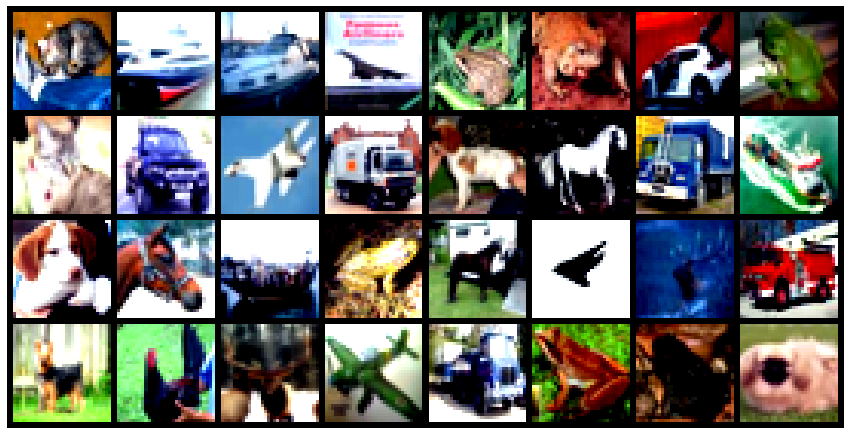

In [ ]:
samples, _ = next(iter(loader_test))
samples = samples.cpu()
samples = make_grid(denorm(samples), nrow=8, padding=2, normalize=False,
                        range=None, scale_each=False, pad_value=0)
plt.figure(figsize = (15,15))
plt.axis('off')
show(samples)


#### Model Definition
Define hyperparameters and the model

In [ ]:
# Choose the number of epochs, the learning rate
# and the size of the Generator's input noise vetor.
num_epochs = 40
learning_rate = 0.0002
latent_vector_size = 100

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of feature maps in generator
ngf = 84

# Size of feature maps in discriminator
ndf = 84


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_vector_size, ngf * 8, 3, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 2, ngf, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf, nc, 2, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_layer = nn.Sequential(

            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),

            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2,1,  bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.seq_layer = nn.Linear(2688,1)
    def forward(self, x, feat_match = False):

        x = self.conv_layer(x)
        feature = x.view(-1,2688)
        output = self.seq_layer(feature).flatten()
        output = nn.Sigmoid()(output)
        if feat_match:
          return feature, output
        return output


<h2> Initialize Model and print number of parameters </h2>

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 3275496
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 672, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(672, 336, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(336, 168, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(168, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(168, 84, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(84, 3, kernel_size=(2, 2), stride=(2, 2),

# Training the Model

#### Defining a Loss

In [ ]:
def loss_function(input, true_label):
    loss = nn.BCELoss()(input, true_label)
    return loss

<h3>Choose and initialize optimizers</h3>

In [ ]:
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))


<h3> Define fixed input vectors to monitor training and mode collapse. </h3>

In [ ]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
# Establish convention for real and fake labels during training
real_label = 0.9
fake_label = 0.

#### Training Loop

In [ ]:
import torchvision.utils as vutils
train_losses_G = []
train_losses_D = []

#Additional lists and a variable for plotting and inner loop
img_list = []
iters = 0
G_losses = []
D_losses = []
K = 2

print("Starting Training Loop...")
for epoch in range(num_epochs):
    train_loss_D = 0
    train_loss_G = 0
    with tqdm.tqdm(loader_train, unit="batch") as tepoch: 
        for i, data in enumerate(tepoch):
            
            # (1) Update D network
            for k in range (K):
              # train with real
              model_D.zero_grad()
              real_cpu = data[0].to(device)
              b_size = real_cpu.size(0)
              label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
              # Forward pass real batch through D
              output = model_D(real_cpu).view(-1)
              # Calculate loss on all-real batch
              errD_real = loss_function(output, label)
              # Calculate gradients for D in backward pass
              errD_real.backward()
              D_x = output.mean().item()


              # train with fake
              # Generate batch of latent vectors
              noise = torch.randn(b_size, latent_vector_size, 1, 1, device=device)
              # Generate fake image batch with G
              fake = model_G(noise)
              label.fill_(fake_label)
              # Classify all fake batch with D
              output = model_D(fake.detach()).view(-1)
              # Calculate D's loss on the all-fake batch
              errD_fake = loss_function(output, label)
              # Calculate the gradients for this batch, accumulated (summed) with previous gradients
              errD_fake.backward()
              D_G_z1 = output.mean().item()
              # Compute error of D as sum over the fake and the real batches
              errD = errD_real + errD_fake

              train_loss_D += errD
              # Update D
              optimizerD.step()

            # (2) Update G network
            model_G.zero_grad()
            # Feature mathcing
            feature_real, _ = model_D(real_cpu, True)
            feature_fake, output = model_D(fake, True)
            feature_real = torch.mean(feature_real,0)
            feature_fake = torch.mean(feature_fake,0)
            errG = nn.MSELoss()(feature_fake, feature_real)

            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            # Calculate G's loss based on this output
            errG_bce = loss_function(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G 
            optimizerG.step()
            train_loss_G += errG_bce

            # Logging 
            if i % 50 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}", D_x=D_x,
                                  Loss_D=errD.item(), Loss_G=errG_bce.item())
            G_losses.append(errG_bce.item())
            D_losses.append(errD.item())
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(loader_train)-1)):
              with torch.no_grad():
                  fake = model_G(fixed_noise).detach().cpu()
              img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

    # Saving 
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))
# save  models 
save_gen_path = "path_gen"
save_disc_path = "path_disc"
torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), save_gen_path)
torch.jit.save(torch.jit.trace(model_D, (fake)), save_disc_path)

# Results


### Visualise Generator samples

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


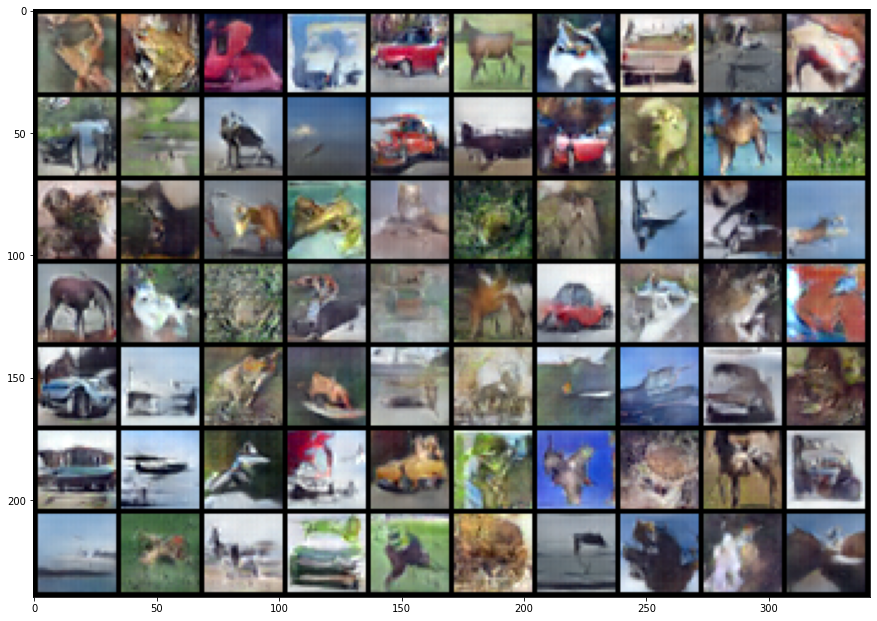

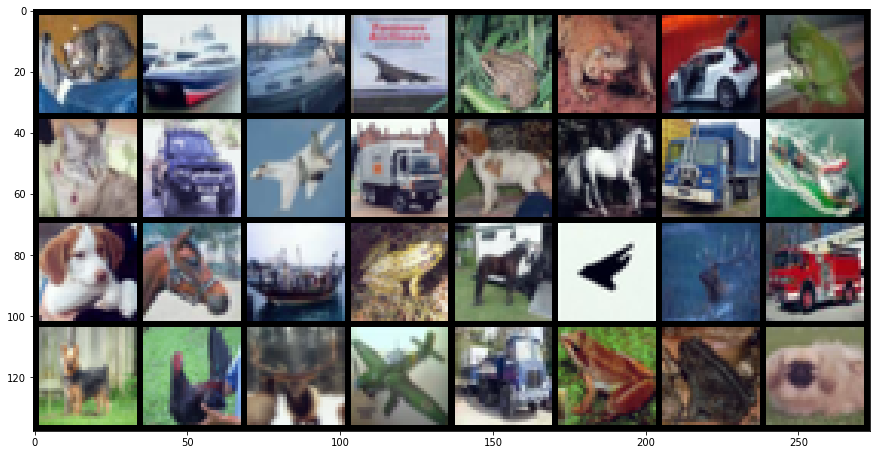

In [ ]:
input_noise = torch.randn(100, latent_vector_size, 1, 1, device=device)
model_G = torch.jit.load(save_gen_path)
model_D = torch.jit.load(save_disc_path)
with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    
    generated = make_grid(denorm(generated)[:70], nrow=10, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    plt.figure(figsize=(15,15))
    show(generated) # note these are now class conditional images columns rep classes 1-10

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:64, :, :, :]
# visualize the original images of the last batch of the test set for comparison
img = make_grid(fixed_input, nrow=8, padding=2, normalize=True,
                range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
show(img)